# Grad -CAM Visualization

The length of smiles character is 56
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.Size([1, 64, 10])
Feature maps shape (last conv layer output): torch.Size([1, 64, 10])
Shape before LSTM: torch.Size([1, 10, 64])
Shape after LSTM: torch.Size([1, 10, 64])
Attention output shape: torch.Size([1, 10, 64])
Output shape after FC layer: torch.Size([1, 1])
Initial input shape: torch.Size([1, 350, 56])
Input shape after permute for conv layers: torch.Size([1, 56, 350])
Shape after conv layer 0: torch.Size([1, 64, 175])
Shape after conv layer 1: torch.Size([1, 64, 87])
Shape after conv layer 2: torch.Size([1, 64, 43])
Shape after conv layer 3: torch.Size([1, 64, 21])
Shape after conv layer 4: torch.S

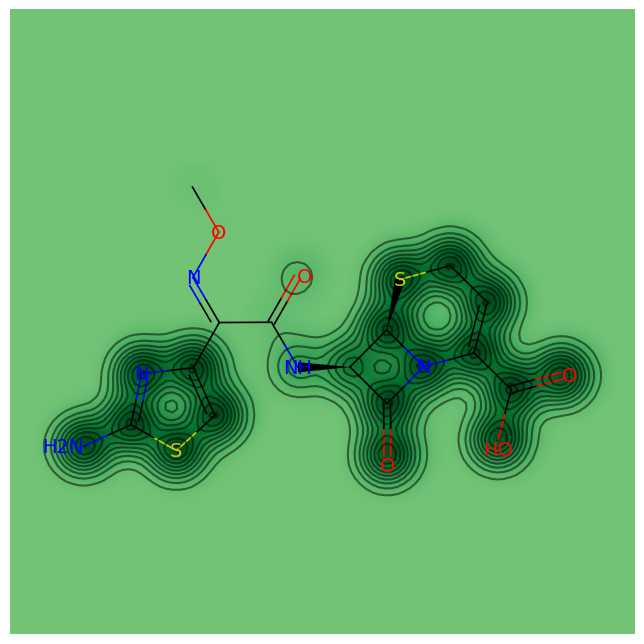

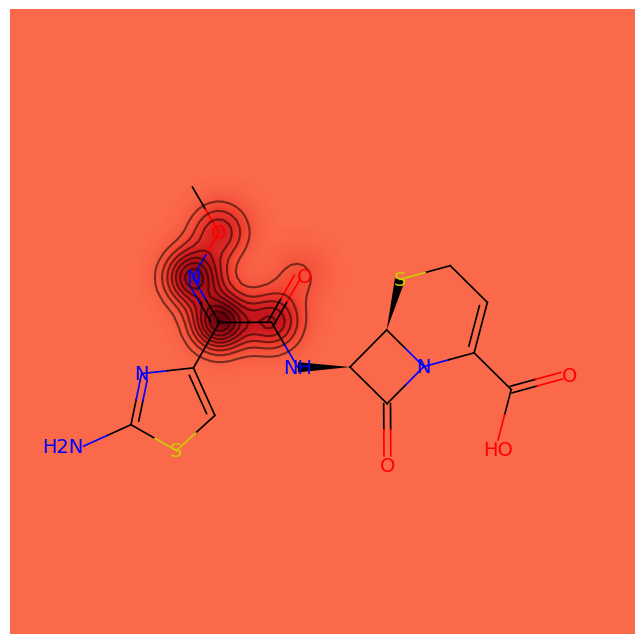

In [1]:
import torch
import numpy as np
from torch.autograd import Function
import torch.nn.functional as F
from model import ConvLSTMCAMbiotic
from data_preprocessing2 import smiles_chars
import random
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.cm as cm
import matplotlib.colors as cc
import os
import matplotlib.colors as mcolors
from rdkit.Chem.Draw import SimilarityMaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from PIL import Image
import warnings
warnings.filterwarnings("ignore", message="The following kwargs were not used by contour: 'fig'")



class ConvLSTMCAMVisualizerGradCAM:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.model.eval()
        self.device = device
        self.char_to_index = {char: idx for idx, char in enumerate(smiles_chars)}
        self.max_len = 350 # Maximum length of SMILES string, you can change if you retrain based on how you trained you rmodel

    def smiles_to_tensor(self, smile):
        encoded = np.zeros((self.max_len, len(self.char_to_index)), dtype=np.int8)
        for i, char in enumerate(smile):
            if char in self.char_to_index and i < self.max_len:
                encoded[i, self.char_to_index[char]] = 1
        encoded_tensor = torch.from_numpy(encoded).to(self.device).float()
        return encoded_tensor.unsqueeze(0)  # Add batch dimension


    def grad_cam(self, input_tensor, target_class):
        self.model.eval()  # Ensure the model is in evaluation mode.
        self.model.zero_grad()  # Reset gradients to zero.

        # Enable gradients for the feature maps
        for param in self.model.parameters():
            param.requires_grad = True

        # Perform the forward pass and capture the outputs.
        logits, _, feature_maps = self.model(input_tensor)

        # Enable gradients for the feature maps
        feature_maps.requires_grad_(True)

        # Since we're dealing with binary classification, squeeze the logits to get a scalar.
        logits = logits.squeeze()

        # Determine the class probability and backpropagate.
        if target_class == "positive":
            class_prob = torch.sigmoid(logits)  # Convert logits to probabilities for positive class.
        else:  # Assuming binary classification, "negative" class
            class_prob = 1 - torch.sigmoid(logits)  # Probabilities for negative class.

        # Since class_prob is now a scalar, we can directly backpropagate.
        class_prob.backward()

        # Get the gradients for the feature maps
        gradients = feature_maps.grad.data

        pooled_gradients = torch.mean(gradients, dim=[0, 2], keepdim=True)  # Average over the batch and length dimensions

        # Weight the feature maps with the pooled gradients
        for i in range(feature_maps.size(1)):  # Iterate over the channels
            feature_maps.data[:, i, :] *= pooled_gradients[:, i, :]  # Use the broadcasted multiplication here

        # Generate the heatmap by averaging across the channels
        heatmap = torch.mean(feature_maps.data, dim=1).squeeze()
        heatmap = F.relu(heatmap)  # Apply ReLU to consider only positive influence

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()



    def interpolate_heatmap_to_atoms(self, smile, heatmap):
        mol = Chem.MolFromSmiles(smile)
        atom_count = mol.GetNumAtoms()
        interpolate = interp1d(np.arange(len(heatmap)), heatmap, kind="linear", fill_value="extrapolate")
        atom_heatmap = interpolate(np.linspace(0, len(heatmap)-1, atom_count))
        return atom_heatmap

    def remove_background(self, image_path, target_class):
        image = Image.open(image_path).convert("RGBA")
        data = np.array(image)
        red, green, blue, alpha = data.T

        remove_areas = (green > 200) if target_class == "positive" else (red > 200)
        data[..., :-1][remove_areas.T] = (255, 255, 255)  # Making the background white
        image = Image.fromarray(data)
        image.save(image_path)

    def overlay_heatmap_on_molecule(self, smile, heatmap, target_class):
        mol = Chem.MolFromSmiles(smile)
        atom_heatmap = self.interpolate_heatmap_to_atoms(smile, heatmap)
        norm = Normalize(vmin=np.min(atom_heatmap), vmax=np.max(atom_heatmap))
        fig, ax = plt.subplots()
        ax.axis('off')
        cmap = "Reds" if target_class == "negative" else "Greens"
        SimilarityMaps.GetSimilarityMapFromWeights(mol, [norm(v) for v in atom_heatmap], colorMap=cmap, fig=fig)
        original_image_path = f"{target_class}_original_GradCAM.png"
        plt.savefig(original_image_path, bbox_inches='tight', dpi=300, transparent=True)
        plt.close(fig)
        self.remove_background(original_image_path, target_class)
        processed_image_path = f"{target_class}_processed_GradCAM.png"
        image = Image.open(original_image_path)
        image.save(processed_image_path)

    def visualize_molecule_with_heatmap(self, smile):
        input_tensor = self.smiles_to_tensor(smile)
        for target_class in ["positive", "negative"]:
            heatmap = self.grad_cam(input_tensor, target_class)
            self.overlay_heatmap_on_molecule(smile, heatmap, target_class)

    def predict_smiles(self, smile):
        input_tensor = self.smiles_to_tensor(smile)
        with torch.no_grad():
            logits, _, _ = self.model(input_tensor)
            probabilities = torch.sigmoid(logits).cpu().numpy()
            prediction = (probabilities >= 0.5).astype(int)
            probability = probabilities[0][0]
            print(f"{smile} is predicted to {'have' if prediction == 1 else 'not have'} antibiotic properties with a probability of {probability:.2f}.")
        return prediction, probability






if __name__ == "__main__":
    
    model_checkpoint_path = 'Reproducibility_200_epochs/models3/checkpoint-epoch=198-val_loss=0.48.ckpt'# replace with model checkpoint path
    trained_model = ConvLSTMCAMbiotic.load_from_checkpoint(model_checkpoint_path)
    visualizer = ConvLSTMCAMVisualizerGradCAM(trained_model, device='cuda' if torch.cuda.is_available() else 'cpu') # Move model to the appropriate device

    # Uncomment the SMILES string you want to visualize
    smiles ='CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=CCS[C@H]12)c1csc(N)n1'# ACTIVE molecule example, change SMILES  to your own molecule
    #smiles = 'CC(C)C1=CC(=O)C(=C(C1c2ccccc2)C(=O)O)C' # INACTIVE molecule example, change SMILES  to your own molecule
    visualizer.visualize_molecule_with_heatmap(smiles)
    prediction, probability = visualizer.predict_smiles(smiles)



